In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from lib.gitlab import SupportTimeSegmenter

plt.style.use('ggplot')

In [2]:
arrivals_data = pd.read_csv('./_inputs/arrival_data_-_up_to_2021-02-28.csv')
arrivals_data['Updates'].fillna(value=0, inplace=True)

In [3]:
# Filter out weekends
weekday_mask = (arrivals_data['Update - Weekday'] != 'Saturday') & (arrivals_data['Update - Weekday'] != 'Sunday')
weekday_arrivals_data = arrivals_data[weekday_mask]

all_update_counts = arrivals_data['Updates'].sum()
weekday_update_counts = weekday_arrivals_data['Updates'].sum()
print('Number of updates before filtering weekends: ' + str(arrivals_data['Updates'].sum()))
print('Number of updates after filtering weekends: ' + str(weekday_arrivals_data['Updates'].sum()))
print('Difference: ' + str(all_update_counts - weekday_update_counts) + ' (' + str(round((1 - weekday_update_counts / all_update_counts) * 100, 2)) + '%)')

Number of updates before filtering weekends: 110991.0
Number of updates after filtering weekends: 105729.0
Difference: 5262.0 (4.74%)


In [4]:
all_hours_data = weekday_arrivals_data.groupby([
    pd.Grouper('Update - Year'),
    pd.Grouper('Update - Month'),
    pd.Grouper('Update - Hour')
]).sum().reset_index()

number_of_days = weekday_arrivals_data.groupby([
    pd.Grouper('Update - Year'),
    pd.Grouper('Update - Month'),
    pd.Grouper('Update - Hour')
]).nunique().reset_index()['Update - Day of month']

all_hours_data['Days in month'] = number_of_days
all_hours_data['Arrival rate'] = all_hours_data['Updates'] / all_hours_data['Days in month']

all_hours_data['Update - Year'] = all_hours_data['Update - Year'].astype(str)
all_hours_data['Month'] = all_hours_data['Update - Year'] + all_hours_data['Update - Month']
all_hours_data['Month'] = pd.to_datetime(all_hours_data['Month'], format='%Y%B')

dst_mask = (all_hours_data['Month'].dt.month >= 4) & (all_hours_data['Month'].dt.month < 11)
all_hours_data['Daylight saving time'] = dst_mask

all_hours_data.sort_values('Month', inplace=True)

<AxesSubplot:xlabel='Update - Hour', ylabel='Arrival rate'>

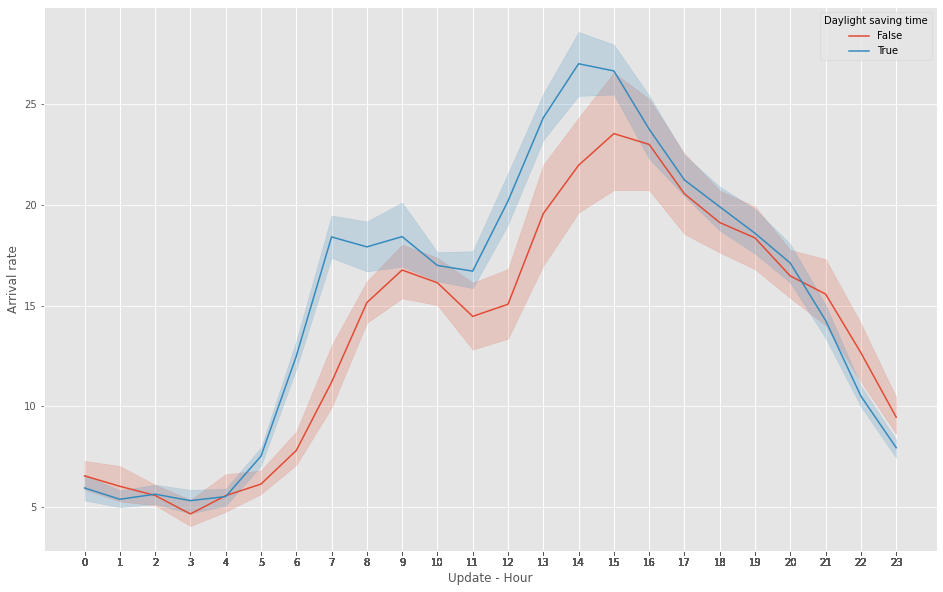

In [5]:
fig, ax = plt.subplots(figsize=[16, 10])
ax.set_xticks(all_hours_data['Update - Hour'])
sns.lineplot(data=all_hours_data, x='Update - Hour', y='Arrival rate', hue='Daylight saving time', ax=ax)

In [6]:
sts = SupportTimeSegmenter(weekday_arrivals_data, 'Update - Hour')

regional_arrivals_data = {
    'AMER-All': sts.get_segment('amer', 'all'),
    'AMER-Early': sts.get_segment('amer', 'early'),
    'AMER-Middle': sts.get_segment('amer', 'middle'),
    'AMER-Late': sts.get_segment('amer', 'late'),
    'APAC-All': sts.get_segment('apac', 'all'),
    'APAC-Early': sts.get_segment('apac', 'early'),
    'APAC-Middle': sts.get_segment('apac', 'middle'),
    'APAC-Late': sts.get_segment('apac', 'late'),
    'EMEA-All': sts.get_segment('emea', 'all'),
    'EMEA-Early': sts.get_segment('emea', 'early'),
    'EMEA-Late': sts.get_segment('emea', 'late'),
}

In [7]:
years = arrivals_data['Update - Year'].unique()
months = arrivals_data['Update - Month'].unique()
forms = arrivals_data['Ticket form'].unique()

arrival_rates_cols = ['Region', 'Form', 'Month', 'Arrival Rate']
arrival_rates_data = []

for region_name, data in regional_arrivals_data.items():
    for year in years:
        year_data = data[data['Update - Year'] == year]

        for month in months:
            month_data = year_data[year_data['Update - Month'] == month]

            for form in forms:
                form_data = month_data[month_data['Ticket form'] == form]
                
                updates_avg = form_data['Updates'].mean()
                if np.isnan(updates_avg): continue

                row_data = [
                    region_name, 
                    form,
                    pd.to_datetime(str(year) + month, format='%Y%B'),
                    form_data['Updates'].mean()
                ]                

                arrival_rates_data.append(row_data)

            row_data = [
                region_name,
                'All',
                pd.to_datetime(str(year) + month, format='%Y%B'),
                month_data['Updates'].mean()
            ]

            arrival_rates_data.append(row_data)

arrival_rates_df = pd.DataFrame(arrival_rates_data, columns=arrival_rates_cols)


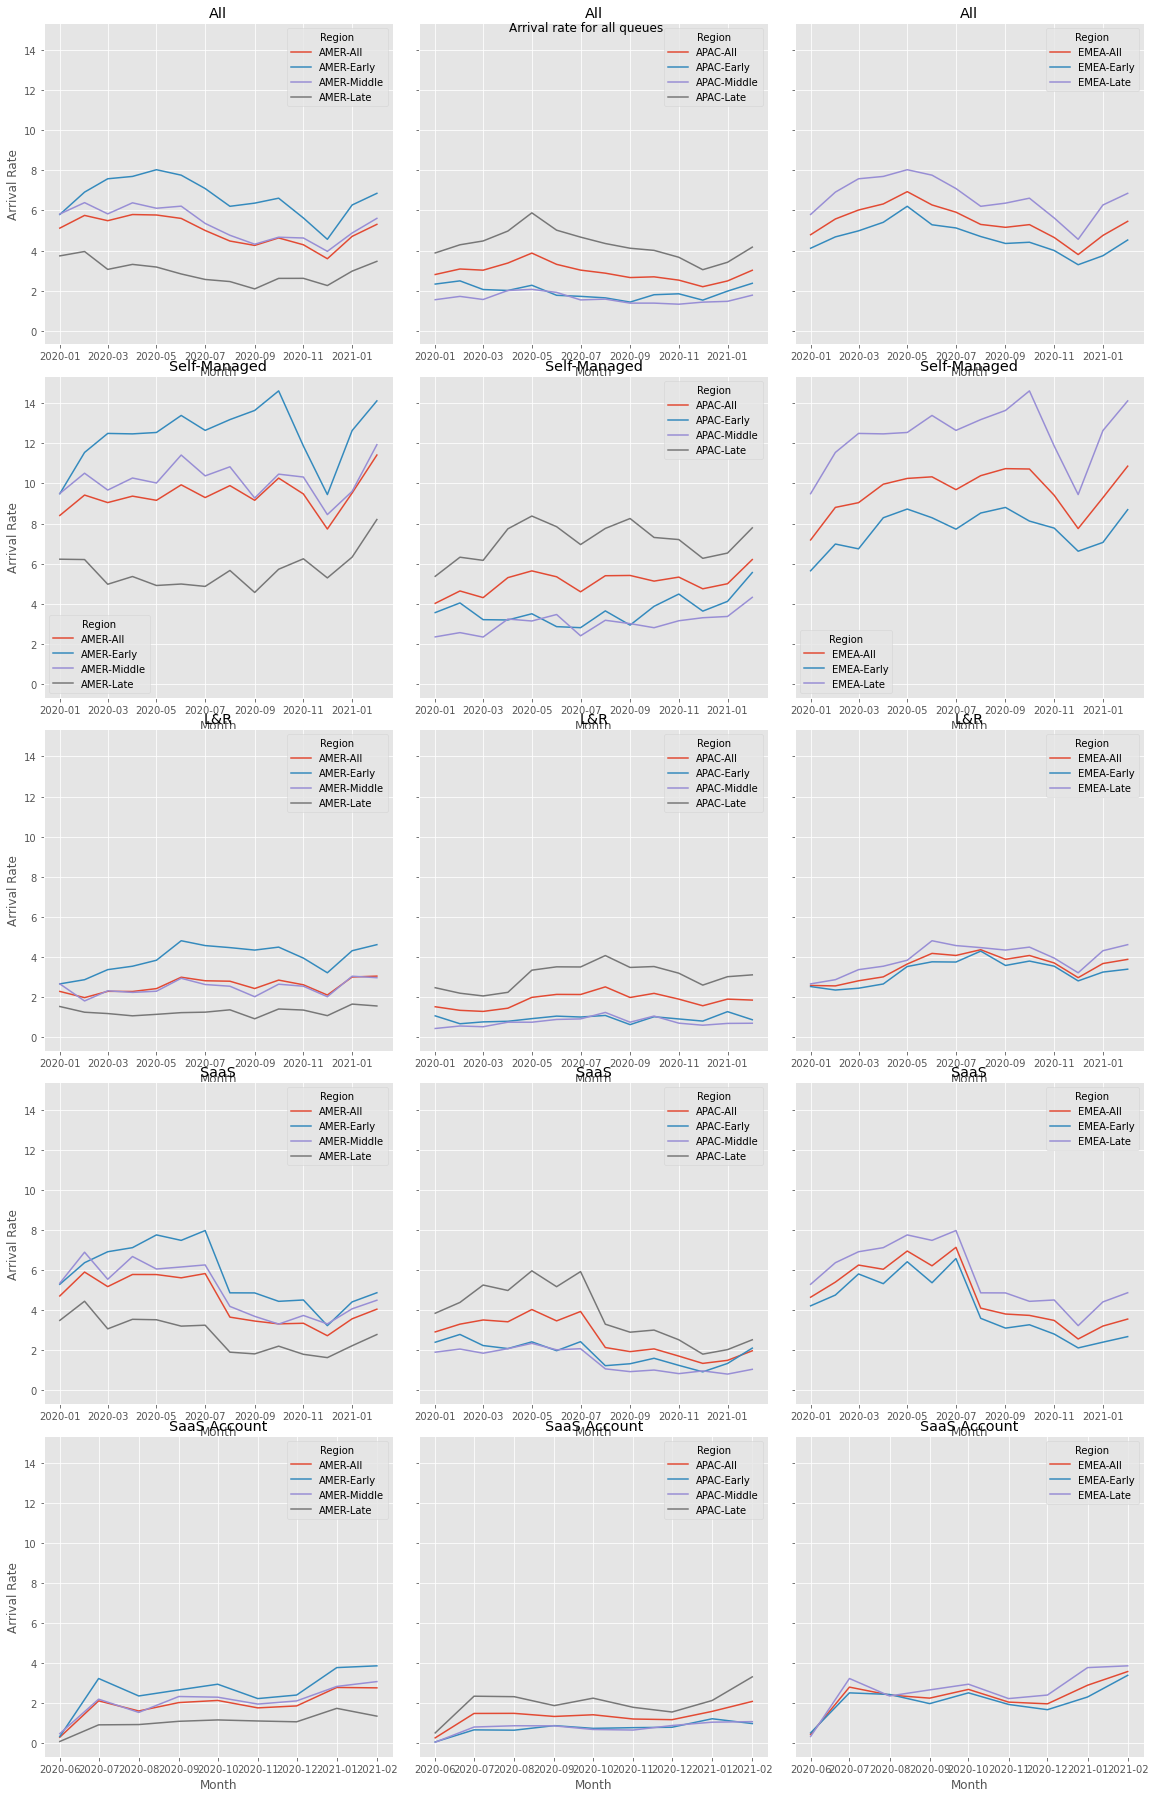

In [8]:
fig, ax = plt.subplots(5, 3, sharey=True, figsize=[16, 25])
fig.suptitle('Arrival rate for all queues')
fig.tight_layout()

for i, form in enumerate(['All', 'Self-Managed', 'L&R', 'SaaS', 'SaaS Account']):
    for j, region in enumerate(['AMER', 'APAC', 'EMEA']):
        mask = (arrival_rates_df['Form'] == form) & (arrival_rates_df['Region'].str.startswith(region))
        data = arrival_rates_df[mask]
        sns.lineplot(data=data, x='Month', y='Arrival Rate', hue='Region', ax=ax[i, j])
        ax[i, j].set_title(form)

plt.show()

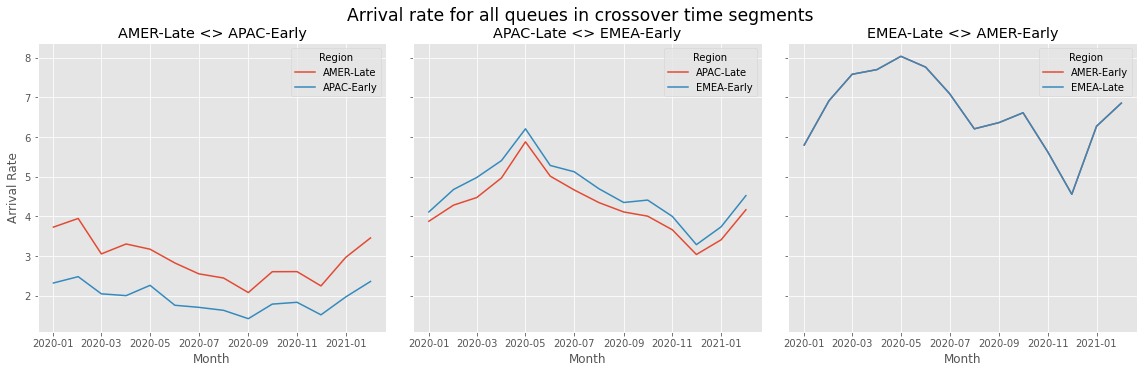

In [9]:

fig, ax = plt.subplots(1, 3, sharey=True, figsize=[16, 5])
fig.suptitle('Arrival rate for all queues in crossover time segments', fontsize='xx-large')
fig.tight_layout()

for i, region_crossover in enumerate([['AMER-Late', 'APAC-Early'], ['APAC-Late', 'EMEA-Early'], ['EMEA-Late', 'AMER-Early']]):
    crossover_mask = (arrival_rates_df['Region'].isin(region_crossover)) & (arrival_rates_df['Form'] == 'All')
    crossover_df = arrival_rates_df[crossover_mask]
    sns.lineplot(data=crossover_df, x='Month', y='Arrival Rate', hue='Region', ax=ax[i])
    ax[i].set_title(' <> '.join(region_crossover))

plt.show()